<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-и-выбор-лучшей-модели" data-toc-modified-id="Обучение-и-выбор-лучшей-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение и выбор лучшей модели</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Проверка-лучшей-модели-на-тестовой-выборке" data-toc-modified-id="Проверка-лучшей-модели-на-тестовой-выборке-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка лучшей модели на тестовой выборке</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Отток клиентов в телекоме

Оператор связи хочет научиться прогнозировать отток клиентов.

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL) или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Требуется спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Основная метрика построенной модели `AUC-ROC`, дополнительная `Accuracy`.

Имеются данные о некоторых клиентах, информация об их тарифах и договорах.

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Анализ данных

Импортируем необходимые библиотеки и инструменты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_recall_curve, precision_score, recall_score
from lightgbm import LGBMClassifier
import datetime
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

Загрузим данные и ознакомимся с ними

In [2]:
try:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')
    
except: # для локальной работы
    contract = pd.read_csv('contract.csv')
    personal = pd.read_csv('personal.csv')
    internet = pd.read_csv('internet.csv')
    phone = pd.read_csv('phone.csv')

In [3]:
datasets = [contract, personal, internet, phone]

In [4]:
i = 0

names = ['Информация о договоре', 'Персональные данные клиента', 'Информация об интернет-услугах', 'Информация об услугах телефонии']

for data in datasets:
    
    print()
    
    print(names[i])
    
    display(data.head())
    
    display(data.info())
    
    print('Количество уникальных ID:', len(data['customerID'].unique()))
    
    print('='*100)
    
    print()
    
    i += 1


Информация о договоре


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

Количество уникальных ID: 7043


Персональные данные клиента


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

Количество уникальных ID: 7043


Информация об интернет-услугах


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


None

Количество уникальных ID: 5517


Информация об услугах телефонии


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


None

Количество уникальных ID: 6361



- В таблицах отсутствуют пропуски.
- В каждой таблице нет повторяющихся ID.
- В таблице `contract` надо изменить тип данных в столбцах `BeginDate` и `EndDate` на формат даты, а в стобце `TotalCharges` на вещественный тип данных.
- В таблице `personal` надо изменить тип данных в столбце `SeniorCitizen` на формат `object`для единообразия с остальными стобцами.

Создадим функцию, устанавливающую столбец `customerID` в качестве индекса выборки.

In [5]:
def set_index_date(data):
    
    ''' Функция для установки индекса выборки '''
    
    data = data.set_index('customerID', inplace=True)

Применим функцию ко всем выборкам.

In [6]:
set_index_date(contract)

set_index_date(personal)

set_index_date(internet)

set_index_date(phone)

Добавим новый столбец данных `Exited` в таблицу `contract`, содержащий информацию о том, что клиент покинул оператора. Также значение `No` в столбце `EndDate` заменим на `2020-02-01 00:00:00` для того, чтобы в дальнейшем вычислить срок длительности договора.

In [7]:
for i in contract.index:
    
    if contract.loc[i, 'EndDate'] == 'No':
        contract.loc[i, 'EndDate'] = '2020-02-01 00:00:00'
        contract.loc[i, 'Exited'] = 0
        
    else:
        contract.loc[i, 'Exited'] = 1
        
contract['Exited'] = contract['Exited'].astype('int') # переводим в целочисленный формат

Изменим тип данных в столбцах `BeginDate` и `EndDate` на формат даты.

In [8]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')

contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d %H:%M:%S').dt.round('1D') # дополнительно уберём лишнюю информацию

Изменим тип данных в столбце `TotalCharges` на вещественный формат.

In [9]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce') 

In [10]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 8 columns):
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
Exited              7043 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 815.2+ KB


В столбце `TotalCharges` появились пропуски. Посмотрим на строки с пропусками.

In [11]:
contract[contract['TotalCharges'] != contract['TotalCharges']]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited
customerID,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0


Пропуски обусловлены тем, что все эти клиенты новые. Удалим информацию о таких клиентах из таблицы, т.к. информацию о таких клиентах нецелесообразно использовать в дальнейшем.

In [12]:
contract = contract.dropna(subset = ['TotalCharges'])

Изменим в таблице `personal` тип данных в столбце `SeniorCitizen` на формат `object`.

In [13]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype('object')

Создадим новую таблицу `customers`, в которую соберём информацию со всех имеющихся таблиц.

In [14]:
customers = contract[['Exited', 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']]

Создадим в таблице `customers` столбец `ContractDays`, содержащий информацию о длительности контракта с клиентом.

In [15]:
customers['ContractDays'] = contract['EndDate'] - contract['BeginDate']

customers['ContractDays'] = (customers['ContractDays'] / np.timedelta64(1,'D')).astype(int) # переводим в целочисленный формат

Убедимся, что минимальная длительность контракта составляет хотя бы один месяц.

In [16]:
customers['ContractDays'].min()

30

Добавим данные из таблиц `personal`, `internet` и `phone`.

In [17]:
customers = customers.join(personal)

customers = customers.join(internet)

customers = customers.join(phone)

In [18]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
Exited              7032 non-null int64
Type                7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
ContractDays        7032 non-null int64
gender              7032 non-null object
SeniorCitizen       7032 non-null object
Partner             7032 non-null object
Dependents          7032 non-null object
InternetService     5512 non-null object
OnlineSecurity      5512 non-null object
OnlineBackup        5512 non-null object
DeviceProtection    5512 non-null object
TechSupport         5512 non-null object
StreamingTV         5512 non-null object
StreamingMovies     5512 non-null object
MultipleLines       6352 non-null object
dtypes: float64(2), int64(2), object(15)
memory usage: 1.4+ MB


Получившиеся пропуски в таблице объясняются тем, что часть клиентов использует только одну из двух основных услуг оператора. Заполним все пропуски значением `None`.

In [19]:
# Находим все столбцы с пропусками

names = customers.columns.tolist()

names_nan = []

for name in names:
    if customers[name].isnull().sum() != 0:
        names_nan.append(name)

In [20]:
# Заполняем пропуски

for name in names_nan:
    
    customers[name] = customers[name].fillna('None')

In [21]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
Exited              7032 non-null int64
Type                7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
ContractDays        7032 non-null int64
gender              7032 non-null object
SeniorCitizen       7032 non-null object
Partner             7032 non-null object
Dependents          7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
MultipleLines       7032 non-null object
dtypes: float64(2), int64(2), object(15)
memory usage: 1.4+ MB


Проанализируем наши данные.

Проверим корректность дат контрактов.

In [22]:
contract[['BeginDate', 'EndDate']].describe()

,BeginDate,EndDate
count,7032,7032
unique,76,5
top,2014-02-01 00:00:00,2020-02-01 00:00:00
freq,366,5163
first,2013-10-01 00:00:00,2019-10-01 00:00:00
last,2020-01-01 00:00:00,2020-02-01 00:00:00


Странных дат в данных нет.

Узнаем долю ушедших клиентов.

In [23]:
customers['Exited'].mean()

0.26578498293515357

Проверим насколько коррелируют данные друг с другом.

In [24]:
customers.corr()

,Exited,MonthlyCharges,TotalCharges,ContractDays
Exited,1.000000,0.192858,-0.199484,-0.354496
MonthlyCharges,0.192858,1.000000,0.651065,0.246715
TotalCharges,-0.199484,0.651065,1.000000,0.825811
ContractDays,-0.354496,0.246715,0.825811,1.000000


Столбец `TotalCharges` коррелирует со столбцами `MonthlyCharges` и `ContractDays`, что логично. Поэтому его не будем использовать для построения модели.

Создадим функцию для построения "ящика с усами".

In [25]:
def plot_boxplot(data, title, whis):
    
    ''' Функция для построения ящика с усами '''

    plt.figure(figsize=(15,5))

    plt.title(title, fontsize=18)

    sns.boxplot(data=data, orient='h', whis=whis)

Создадим функцию для построения гистограммы.

In [26]:
def plot_histplot(data, title, xlabel, bins, min, max):
    
    ''' Функция для построения гистограммы '''

    plt.figure(figsize=(15,5))

    plt.title(title, fontsize=18)
    
    plt.ylabel('Количество, шт.', fontsize=18)
    
    plt.xlabel(xlabel, fontsize=18)

    data.hist(bins=bins, range = (min, max), figsize = (15, 5))

Построим "ящик с усами" для ежемесячной оплаты, при этом усы зададим равными 3IQR (соответствует очень грубым выбросам).

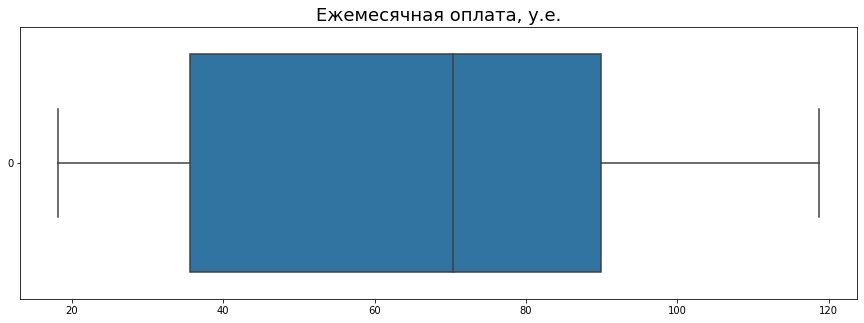

In [27]:
plot_boxplot(customers['MonthlyCharges'], 'Ежемесячная оплата, у.е.', 3)

Видим, что грубых выбросов нет.

Построим гистограмму для ежемесячной оплаты.

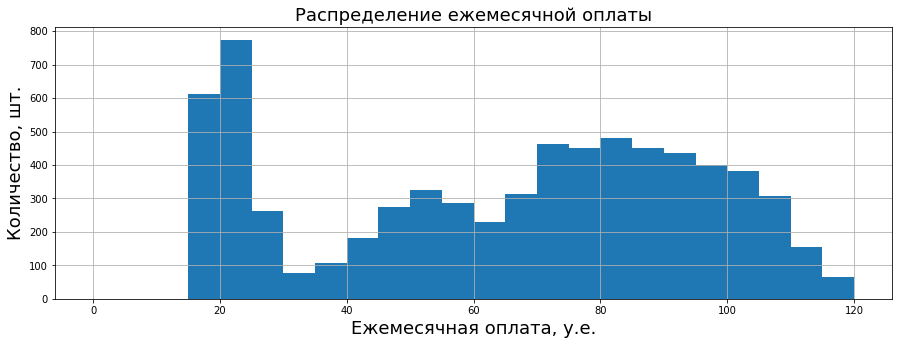

In [28]:
plot_histplot(customers['MonthlyCharges'], 'Распределение ежемесячной оплаты', 'Ежемесячная оплата, у.е.', 24, 0, 120)

Большинство клиентов платят в диапазоне 15-25 у.е. в месяц.

Построим "ящик с усами" для длительности действия контракта, при этом усы зададим равными 3IQR (соответствует очень грубым выбросам).

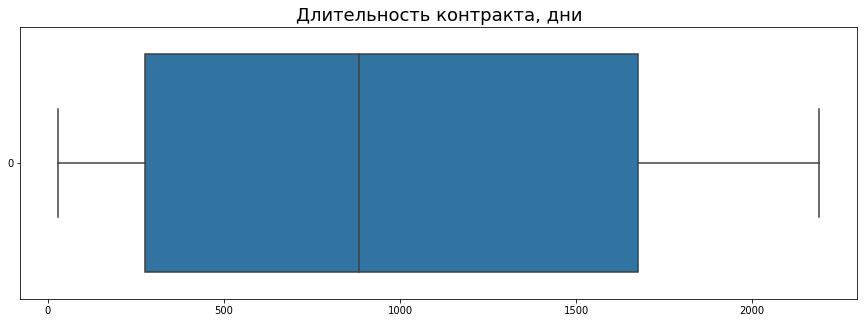

In [29]:
plot_boxplot(customers['ContractDays'], 'Длительность контракта, дни', 3)

Видим, что грубых выбросов нет.

Построим гистограмму для длительности контракта.

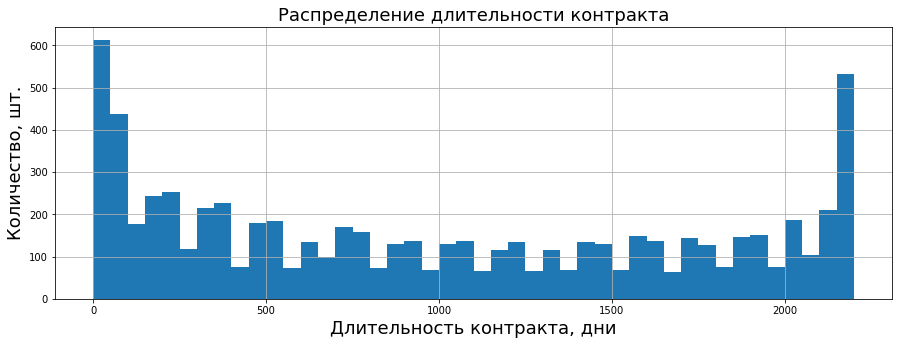

In [30]:
plot_histplot(customers['ContractDays'], 'Распределение длительности контракта', 'Длительность контракта, дни', 44, 0, 2200)

Преобладают контракты с небольшой длительностью в диапазоне до 100 дней и большой длительностью в диапазоне от 2150 до 2200 дней.

Посмотрим как распределяются данные в зависимости от того ушёл клиент или нет.

Построим гистограммы распределения количества новых контрактов по месяцам для лояльных и ушедших клиентов. 

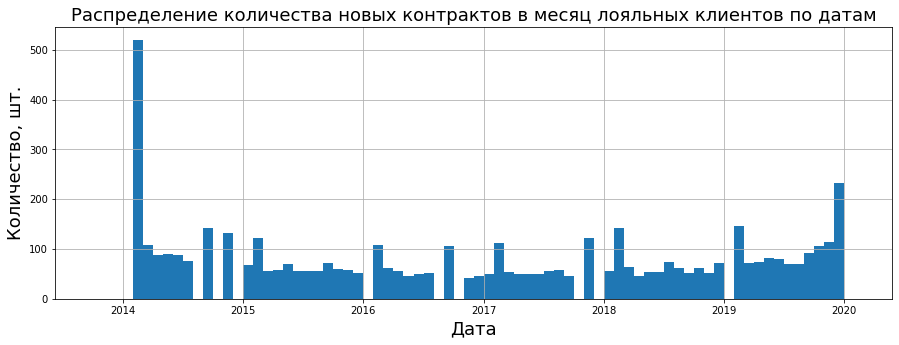

In [31]:
plot_histplot(contract[contract['Exited'] == 0]['BeginDate'], 'Распределение количества новых контрактов в месяц лояльных клиентов по датам', 'Дата', 76, '2013-10-01', '2020-02-01')

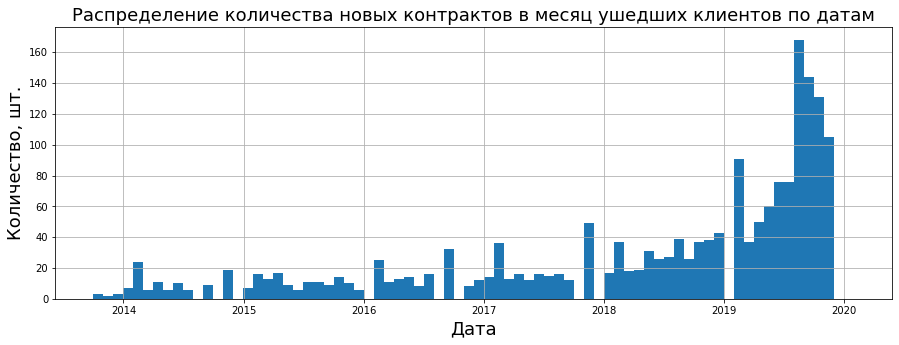

In [32]:
plot_histplot(contract[contract['Exited'] == 1]['BeginDate'], 'Распределение количества новых контрактов в месяц ушедших клиентов по датам', 'Дата', 76, '2013-10-01', '2020-02-01')

- Заметен небольшой рост новых клиентов оператора, но также наблюдается значительный рост ушедших клиентов среди них.
- В реальном бизнесе следует обсудитьить с коллегами пик новых контрактов и пропуски. 

Создадим в таблице `contract` столбец `NewCustomer`, содержащий информацию о том, что клиент новый (договор заключён в 2019-2020 годах).

In [33]:
date = datetime.date(2018, 12, 31)

for i in contract.index:

    if contract.loc[i, 'BeginDate'] > date:
        contract.loc[i, 'NewCustomer'] = 'Yes'
    
    else:
        contract.loc[i, 'NewCustomer'] = 'No'

Добавим этот столбец в таблицу `customers`.

In [34]:
customers['NewCustomer'] = contract['NewCustomer']

Сохраним названия столбцов таблицы `customers` с типоп данных `object` для дальнейшего анализа.

In [35]:
names = customers.columns.tolist()

datatypes = customers.dtypes

names_obj = []

for name in names:
    if datatypes[name] == 'O':
        names_obj.append(name)

Проанализируем данные в этих столбцах.

In [36]:
for name in names_obj:
    
    print()
    
    print('Название столбца:', name)
    
    print()
    
    print('Доли для лояльных клиентов:')
    
    display(customers[customers['Exited'] == 0][name].value_counts(normalize=1))
    
    print()
    
    print('Доли для ушедших клиентов:')
    
    display(customers[customers['Exited'] == 1][name].value_counts(normalize=1))
    
    print('='*100)
    
    print()


Название столбца: Type

Доли для лояльных клиентов:


Month-to-month    0.429983
Two year          0.317064
One year          0.252954
Name: Type, dtype: float64


Доли для ушедших клиентов:


Month-to-month    0.885500
One year          0.088818
Two year          0.025682
Name: Type, dtype: float64



Название столбца: PaperlessBilling

Доли для лояльных клиентов:


Yes    0.536122
No     0.463878
Name: PaperlessBilling, dtype: float64


Доли для ушедших клиентов:


Yes    0.749064
No     0.250936
Name: PaperlessBilling, dtype: float64



Название столбца: PaymentMethod

Доли для лояльных клиентов:


Mailed check                 0.251017
Electronic check             0.250629
Credit card (automatic)      0.249661
Bank transfer (automatic)    0.248693
Name: PaymentMethod, dtype: float64


Доли для ушедших клиентов:


Electronic check             0.573034
Mailed check                 0.164794
Bank transfer (automatic)    0.138042
Credit card (automatic)      0.124131
Name: PaymentMethod, dtype: float64



Название столбца: gender

Доли для лояльных клиентов:


Male      0.507263
Female    0.492737
Name: gender, dtype: float64


Доли для ушедших клиентов:


Female    0.502408
Male      0.497592
Name: gender, dtype: float64



Название столбца: SeniorCitizen

Доли для лояльных клиентов:


0    0.871005
1    0.128995
Name: SeniorCitizen, dtype: float64


Доли для ушедших клиентов:


0    0.745318
1    0.254682
Name: SeniorCitizen, dtype: float64



Название столбца: Partner

Доли для лояльных клиентов:


Yes    0.5276
No     0.4724
Name: Partner, dtype: float64


Доли для ушедших клиентов:


No     0.642055
Yes    0.357945
Name: Partner, dtype: float64



Название столбца: Dependents

Доли для лояльных клиентов:


No     0.656595
Yes    0.343405
Name: Dependents, dtype: float64


Доли для ушедших клиентов:


No     0.825575
Yes    0.174425
Name: Dependents, dtype: float64



Название столбца: InternetService

Доли для лояльных клиентов:


DSL            0.379043
Fiber optic    0.348441
None           0.272516
Name: InternetService, dtype: float64


Доли для ушедших клиентов:


Fiber optic    0.693954
DSL            0.245586
None           0.060460
Name: InternetService, dtype: float64



Название столбца: OnlineSecurity

Доли для лояльных клиентов:


No      0.394344
Yes     0.333140
None    0.272516
Name: OnlineSecurity, dtype: float64


Доли для ушедших клиентов:


No      0.781701
Yes     0.157838
None    0.060460
Name: OnlineSecurity, dtype: float64



Название столбца: OnlineBackup

Доли для лояльных клиентов:


Yes     0.368390
No      0.359094
None    0.272516
Name: OnlineBackup, dtype: float64


Доли для ушедших клиентов:


No      0.659711
Yes     0.279829
None    0.060460
Name: OnlineBackup, dtype: float64



Название столбца: DeviceProtection

Доли для лояльных клиентов:


No      0.364710
Yes     0.362774
None    0.272516
Name: DeviceProtection, dtype: float64


Доли для ушедших клиентов:


No      0.64794
Yes     0.29160
None    0.06046
Name: DeviceProtection, dtype: float64



Название столбца: TechSupport

Доли для лояльных клиентов:


No      0.392408
Yes     0.335077
None    0.272516
Name: TechSupport, dtype: float64


Доли для ушедших клиентов:


No      0.773676
Yes     0.165864
None    0.060460
Name: TechSupport, dtype: float64



Название столбца: StreamingTV

Доли для лояльных клиентов:


Yes     0.365873
No      0.361611
None    0.272516
Name: StreamingTV, dtype: float64


Доли для ушедших клиентов:


No      0.504013
Yes     0.435527
None    0.060460
Name: StreamingTV, dtype: float64



Название столбца: StreamingMovies

Доли для лояльных клиентов:


Yes     0.370521
No      0.356963
None    0.272516
Name: StreamingMovies, dtype: float64


Доли для ушедших клиентов:


No      0.501873
Yes     0.437667
None    0.060460
Name: StreamingMovies, dtype: float64



Название столбца: MultipleLines

Доли для лояльных клиентов:


No      0.491187
Yes     0.410033
None    0.098780
Name: MultipleLines, dtype: float64


Доли для ушедших клиентов:


Yes     0.454789
No      0.454254
None    0.090958
Name: MultipleLines, dtype: float64



Название столбца: NewCustomer

Доли для лояльных клиентов:


No     0.765834
Yes    0.234166
Name: NewCustomer, dtype: float64


Доли для ушедших клиентов:


Yes    0.52488
No     0.47512
Name: NewCustomer, dtype: float64

Только для столбцов `gender` и `MultipleLines` нет особой разницы в долях для лояльных и ушедших клиентов

Всех клиентов можно разделить на три группы:
- использующих обе основные услуги;
- использующих только стационарную телефонную связь;
- использующих только интернет.

Посмотрим на долю ушедших клиентов в этих групппах.

In [37]:
print('Доля ушедших клиентов, использующих обе услуги:', customers[(customers['InternetService'] != 'None') & (customers['MultipleLines'] != 'None')]['Exited'].mean(),
     '| их количество:', customers[(customers['InternetService'] != 'None') & (customers['MultipleLines'] != 'None')]['Exited'].count())

print()

print('Доля ушедших клиентов, использующих только стационарную телефонную связь:', customers[customers['InternetService'] == 'None']['Exited'].mean(),
     '| их количество:', customers[customers['InternetService'] == 'None']['Exited'].count())

print()

print('Доля ушедших клиентов, использующих только интернет:', customers[customers['MultipleLines'] == 'None']['Exited'].mean(),
     '| их количество:', customers[customers['MultipleLines'] == 'None']['Exited'].count())

Доля ушедших клиентов, использующих обе услуги: 0.32822847682119205 | их количество: 4832

Доля ушедших клиентов, использующих только стационарную телефонную связь: 0.07434210526315789 | их количество: 1520

Доля ушедших клиентов, использующих только интернет: 0.25 | их количество: 680


- Самыми лояльными клиентами являются те, кто использует только стационарную телефонную связь. 
- Больше всего клиентов, которые используют обе основные услуги, и среди них самая большая доля ушедших клиентов. 

### Выводы

- Оператору стоит обратить внимание на самую многочисленную группу клиентов (используют обе основные услуги), т.к. среди них самая большая доля ушедших клиентов.
- Также много уходящих клиентов среди новых (пришедшие сначала 2019 года).
- Столбец `TotalCharges` не будет использоваться для построения модели из-за его корреляции с другими столбцами, а столбцы `gender` и `MultipleLines` - из-за отсутствия информативности для решени поставленной задачи.
- Для решения поставленной задачи созданы новые столбцы `NewCustomer` (хранит признак нового клиента) и `ContractDays` (хранит информацию о сроке действия контракта).
- В данных есть дисбаланс целевого признака.

## Подготовка данных

Удалим из таблицы `customers` столбцы, которые не будет использовать для построения модели, и сбросим индексы.

In [38]:
customers = customers.drop(['TotalCharges', 'gender', 'MultipleLines'], axis=1)

customers = customers.reset_index(drop=True)

Сохраним названия столбцов таблицы `customers`, в которых храняться категориальные данные и количественные, в разные переменные.

In [39]:
names = customers.columns.tolist()

datatypes = customers.dtypes

categorical = []
numeric = []

for name in names:
    if datatypes[name] == 'O':
        categorical.append(name)
        
    else:
        numeric.append(name)

Сохраним в новой таблице категориальные данные, закодированные порядковым кодировщиком.

In [40]:
encoder = OrdinalEncoder()

df = pd.DataFrame(encoder.fit_transform(customers[categorical]), columns=customers[categorical].columns)

Добавим в эту таблицу количественные данные.

In [41]:
df[numeric] = customers[numeric]

Сохраним целевой признак и остальные признаки по отдельности.

In [42]:
target = df['Exited']

features = df.drop('Exited', axis=1)

Разделим данные на обучающую и тестовую выборки таким образом, чтобы доли целевого признака в них были одинаковыми.

In [43]:
features_train, features_test, target_train, target_test = train_test_split(
features, target, test_size=0.3, random_state=12345, stratify=target)

Проверим, что целевой признак в выборках имеет равные доли.

In [44]:
target_train.mean()

0.2657456318569687

In [45]:
target_test.mean()

0.26587677725118486

Выполним масштабирование количественных признаков.

In [46]:
numeric = ['MonthlyCharges', 'ContractDays']

scaler = StandardScaler()

scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])

features_test[numeric] = scaler.transform(features_test[numeric])

## Обучение и выбор лучшей модели

Создадим функцию, которая будет искать и возвращать лучшие гиперпараметры выбранного алгоритма, ориентируясь на AUC-ROC и возвращая лучшее значение AUC-ROC.

In [47]:
def best_model(model, features, target, param_grid):
    
    ''' Функция для решётчатого поиска лучших гиперпараметров модели с кросс-валидацией '''
    
    clf = model(random_state=12345)
    
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc')
    
    grid_search.fit(features, target)
    
    best_params = grid_search.best_params_
    
    best_score = grid_search.best_score_
    
    return best_params, best_score

Создадим функцию, проверяющую лучшее значение гиперпараметра и корректирующую его при необходимости для дальнейшей подстройки модели

In [48]:
def param_check(param): # чтобы диапазон поиска лучшего значения гиперпараметра оставался положительным
    
    ''' Функция для проверки и корректировки гиперпараметров '''
    
    if param > 3:
        param = param
    else:
        param +=3
    return param

Применим функцию поиска лучших гиперпараметров для алгоритма случайного леса с начальными гиперпараметрами, учтя дисбаланс целевого признака.

In [49]:
param_grid = {'n_estimators': [10, 20, 30, 40], 'max_depth': [5, 10, 15, 20], 'class_weight': ['balanced']}

In [50]:
best_params_rf, best_score_rf = best_model(RandomForestClassifier, features_train, target_train, param_grid)
print('Лучшие гиперпараметры:', best_params_rf)
print('Лучшая AUC-ROC:', best_score_rf)

Лучшие гиперпараметры: {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 40}
Лучшая AUC-ROC: 0.8529527861736893


Применим функцию проверки и корректировки гиперпараметра.

In [51]:
max_depth_rf = param_check(best_params_rf['max_depth'])
n_estimators_rf = param_check(best_params_rf['n_estimators'])

Произведём более тонкий поиск лучших гиперпараметров для случайного леса.

In [52]:
param_grid = {'n_estimators': [x for x in range(n_estimators_rf - 3, n_estimators_rf + 3)], 
              'max_depth': [x for x in range(max_depth_rf - 3, max_depth_rf + 3)], 'class_weight': ['balanced']}

In [53]:
best_params_rf, best_score_rf = best_model(RandomForestClassifier, features_train, target_train, param_grid)
print('Лучшие гиперпараметры:', best_params_rf)
print('Лучшая AUC-ROC:', best_score_rf)

Лучшие гиперпараметры: {'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 37}
Лучшая AUC-ROC: 0.8593097548183536


Применим функцию поиска лучших гиперпараметров для алгоритма LightGBM с начальными гиперпараметрами, учтя дисбаланс целевого признака и предварительно изменив формат категориальных данных.

In [54]:
features_train[categorical] = features_train[categorical].astype('category')
features_test[categorical] = features_test[categorical].astype('category')

In [55]:
param_grid = {'n_estimators': [10, 50], 'max_depth': [2, 5, 10], 'num_leaves': [2, 20, 100], 'class_weight': ['balanced']}

In [56]:
best_params_lgbm, best_score_lgbm = best_model(LGBMClassifier, features_train, target_train, param_grid)
print('Лучшие гиперпараметры:', best_params_lgbm)
print('Лучшая AUC-ROC:', best_score_lgbm)

Лучшие гиперпараметры: {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 50, 'num_leaves': 20}
Лучшая AUC-ROC: 0.8870385150758784


Произведём более тонкий поиск лучших гиперпараметров для LightGBM.

In [57]:
max_depth_lgbm = param_check(best_params_lgbm['max_depth'])
n_estimators_lgbm = param_check(best_params_lgbm['n_estimators'])
num_leaves_lgbm = param_check(best_params_lgbm['num_leaves'])

In [58]:
param_grid = {'n_estimators': [x for x in range(n_estimators_lgbm - 3, n_estimators_lgbm + 3)],
              'num_leaves': [x for x in range(num_leaves_lgbm - 3, num_leaves_lgbm + 3)],
              'max_depth': [x for x in range(max_depth_lgbm - 3, max_depth_lgbm + 3)], 'class_weight': ['balanced']}

In [59]:
best_params_lgbm, best_score_lgbm = best_model(LGBMClassifier, features_train, target_train, param_grid)
print('Лучшие гиперпараметры:', best_params_lgbm)
print('Лучшая AUC-ROC:', best_score_lgbm)

Лучшие гиперпараметры: {'class_weight': 'balanced', 'max_depth': 11, 'n_estimators': 52, 'num_leaves': 21}
Лучшая AUC-ROC: 0.8907510332752377


### Вывод

In [60]:
print('Лучший результат показал алгоритм LightGBM с метрикой AUC-ROC:', best_score_lgbm.round(3))

Лучший результат показал алгоритм LightGBM с метрикой AUC-ROC: 0.891


## Проверка лучшей модели на тестовой выборке

Обучим финальную модель LightGBM с лучшими гиперпараметрами.

In [61]:
model = LGBMClassifier(random_state=12345, class_weight='balanced', n_estimators=best_params_lgbm['n_estimators'], 
                               max_depth=best_params_lgbm['max_depth'], num_leaves=best_params_lgbm['num_leaves'])

Посчитаем метрику `Accuracy` модели для тестовой выборки.

In [62]:
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
accuracy = accuracy_score(target_test, predicted_test).round(3)
print('Accuracy финальной модели:', accuracy)

Accuracy финальной модели: 0.811


Посчитаем метрику `AUC-ROC` модели для тестовой выборки.

In [63]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test).round(3)
print('AUC-ROC финальной модели:', auc_roc)

AUC-ROC финальной модели: 0.894


Построим ROC-кривую для итоговой модели.

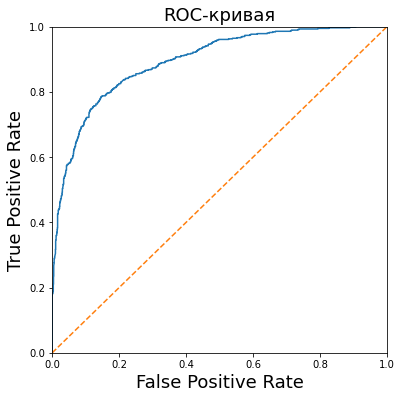

In [64]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)

plt.title('ROC-кривая', fontsize=18)
plt.show()

Выведем матрицу несоответствий для итоговой модели.

In [65]:
tn, fp, fn, tp = confusion_matrix(target_test, predicted_test).ravel()

print('Количество истинно-отрицательных предсказаний:', tn)
print()
print('Количество истинно-положительных предсказаний:', tp)
print()
print('Количество ложно-отрицательных предсказаний:', fn)
print()
print('Количество ложно-положительных предсказаний:', fp)

Количество истинно-отрицательных предсказаний: 1254

Количество истинно-положительных предсказаний: 457

Количество ложно-отрицательных предсказаний: 104

Количество ложно-положительных предсказаний: 295


Количесвто ложно-отрицательных предсказаний меньше количесвта ложно-положительных. Это является плюсом модели, т.к. ложно-отрицательные предсказания обходятся оператору дороже (информация от тимлида).

## Выводы

- Финальная модель на основе алгоритма LightGBM имеет довольно высокий `AUC-ROC`:

In [66]:
auc_roc

0.894

- Финальная модель имеет `Accuracy`:

In [67]:
accuracy

0.811

- Количесвто ложно-отрицательных предсказаний меньше количесвта ложно-положительных.
- Настройкой порога классификации можно менять метрики финальной модели (кроме `AUC-ROC`), в том числе немного повысить `Accuracy`, но тогда ухудшится соотношение ложно-отрицательных и ложно-положительных предсказаний.